# Audio Mining Notebook, Spring Rotation 2025, SALT Lab
Steven Dillmann, Stanford University, stevendi@stanford.edu

In [18]:
# External imports
from datasets import load_dataset
from datasets import concatenate_datasets
import os
from huggingface_hub import login
from IPython.display import Audio, display
import requests
import soundfile as sf
import io
from dotenv import load_dotenv
from cartesia import Cartesia
from cartesia.voice_changer.client import VoiceChangerClient
import wizmap 
from sentence_transformers import SentenceTransformer
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import umap
import numpy as np
np.Infinity = np.inf

# Internal imports
from utils.voice_changer import VoiceChanger

# API Keys
load_dotenv()
hf_key = os.getenv("HF_API_KEY")
cartesia_key = os.getenv(("CARTESIA_API_KEY"))
login(hf_key)
os.environ["CARTESIA_API_KEY"] = cartesia_key


## 1. Data

#### Load Data

In [ ]:
# === Load Data ===

# Load the dataset
gs = load_dataset("speechcolab/gigaspeech", "xs", trust_remote_code=True)
gs = concatenate_datasets([ds for ds in gs.values()])
print(gs)

Dataset({
    features: ['segment_id', 'speaker', 'text', 'audio', 'begin_time', 'end_time', 'audio_id', 'title', 'url', 'source', 'category', 'original_full_path'],
    num_rows: 41758
})


#### Display Audio Data 

In [3]:
# === Display Audio Example ===

# Choose example
example_id = 1
audio_input = gs[example_id]["audio"] 
transcription = gs[example_id]["text"]
full_path = gs[example_id]["original_full_path"]

# Display the audio
display(Audio(audio_input["array"], rate=audio_input["sampling_rate"]))
print("Transcription:", transcription)
print("Original Full Path:", full_path)

# Save the audio to a file .wav
sf.write("audio.wav", audio_input["array"], audio_input["sampling_rate"])

# Load the audio file
# audio, samplerate = sf.read("audio.wav")
# print("Audio shape:", audio.shape)
# print("Sample rate:", samplerate)

Transcription: SIX TOMATOES <PERIOD>
Original Full Path: audio/audiobook/P0011/AUD0000001043.opus


#### Stitch Audio Data

In [4]:
# === Stitch Audio ===

# Filter for the same full path
df_path = gs.filter(lambda example: example["original_full_path"] == full_path)
print("Number of examples with the same full path:", len(df_path))

# Stitch the audio
df_path = df_path.sort("segment_id")
for i in range(10):
  print(df_path[i]['segment_id'])
  print(df_path[i]['text'])
  display(Audio(df_path[i]["audio"]["array"], rate=df_path[i]["audio"]["sampling_rate"]))

Number of examples with the same full path: 1057
AUD0000001043_S0000006
BUT BEYOND THIS POINT THE SITUATION WAS BITTER <PERIOD>


AUD0000001043_S0000007
HIS TWO KIDS <COMMA> BUBS <COMMA> SEVEN <COMMA> AND EVELYN <COMMA> NINE CLAD IN SPACE-SUITS THAT WERE SLIGHTLY OVERSIZE TO ALLOW FOR THE GROWTH OF YOUNG BODIES WERE BOTH BAWLING <PERIOD>


AUD0000001043_S0000008
HE COULD HEAR THEM THROUGH HIS OXYGEN-HELMET RADIOPHONES <PERIOD>


AUD0000001043_S0000010
AT HIS ELBOW <COMMA> HIS WIFE <COMMA> ROSE <COMMA> HER HEART-SHAPED FACE AND GREY EYES FRAMED BY THE WIDE FACE-WINDOW OF HER ARMOR <COMMA>


AUD0000001043_S0000011
WAS TRYING DESPERATELY TO CHOKE BACK TEARS <COMMA> AND BE BRAVE <PERIOD>


AUD0000001043_S0000012
REMEMBER WE'VE GOT TO MAKE GOOD HERE <COMMA> JOHNNY <COMMA>


AUD0000001043_S0000013
SHE WAS SAYING <PERIOD>


AUD0000001043_S0000014
REMEMBER WHAT THE HOMESTEADERS OFFICE PEOPLE TOLD US THAT WITH MODERN EQUIPMENT AND THE RIGHT FRAME OF MIND <COMMA>


AUD0000001043_S0000015
LIFE CAN BE NICE OUT HERE <PERIOD>


AUD0000001043_S0000016
IT'S WORKED ON OTHER ASTEROIDS <PERIOD>


## 2. Voice Changer

In [5]:
# List voices
client = Cartesia(api_key=cartesia_key)

# Get all available Voices
voices = client.voices.list()
for voice in voices:
    print(voice)

id='bf0a246a-8642-498a-9950-80c35e9276b5' is_owner=False name='Sophie' description='A calm, conversational, feminine voice perfect for narration stories or on phone calls. ' created_at=datetime.datetime(2025, 3, 4, 23, 21, 59, 352339, tzinfo=TzInfo(UTC)) embedding=None is_starred=None language='en' mode='similarity' gender='feminine'
id='78ab82d5-25be-4f7d-82b3-7ad64e5b85b2' is_owner=False name='Savannah' description='A smooth, calm Southern female voice. ' created_at=datetime.datetime(2025, 3, 28, 16, 52, 5, 136774, tzinfo=TzInfo(UTC)) embedding=None is_starred=None language='en' mode='similarity' gender='feminine'
id='6f84f4b8-58a2-430c-8c79-688dad597532' is_owner=False name='Brooke' description='A friendly and natural American female voice that feels warm, engaging, and easy to listen to in any conversation.' created_at=datetime.datetime(1970, 4, 18, 0, 0, 20, tzinfo=TzInfo(UTC)) embedding=None is_starred=None language='en' mode='similarity' gender='feminine'
id='a8a1eb38-5f15-4c1d-

In [6]:
# Change voice
vc = VoiceChanger(api_key = cartesia_key, config_path="utils/configs/voice_changer_config.yaml")
input_audio_path = "audio.wav"
output_audio_path = "audio_changed.wav"
vc.run_pipeline(input_audio_path, output_audio_path)

✅ Voice transformation successful.


In [7]:
# Stitch the audio
df_path = df_path.sort("segment_id")
for i in range(10):
  print(df_path[i]['segment_id'])
  print(df_path[i]['text'])
  audio_input = df_path[i]["audio"] 
  # save the audio to a file
  sf.write(f"audio{i}.wav", audio_input["array"], audio_input["sampling_rate"])
  vc.run_pipeline(f"audio{i}.wav", f"audio_changed{i}.wav")


AUD0000001043_S0000006
BUT BEYOND THIS POINT THE SITUATION WAS BITTER <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000007
HIS TWO KIDS <COMMA> BUBS <COMMA> SEVEN <COMMA> AND EVELYN <COMMA> NINE CLAD IN SPACE-SUITS THAT WERE SLIGHTLY OVERSIZE TO ALLOW FOR THE GROWTH OF YOUNG BODIES WERE BOTH BAWLING <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000008
HE COULD HEAR THEM THROUGH HIS OXYGEN-HELMET RADIOPHONES <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000010
AT HIS ELBOW <COMMA> HIS WIFE <COMMA> ROSE <COMMA> HER HEART-SHAPED FACE AND GREY EYES FRAMED BY THE WIDE FACE-WINDOW OF HER ARMOR <COMMA>
✅ Voice transformation successful.


AUD0000001043_S0000011
WAS TRYING DESPERATELY TO CHOKE BACK TEARS <COMMA> AND BE BRAVE <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000012
REMEMBER WE'VE GOT TO MAKE GOOD HERE <COMMA> JOHNNY <COMMA>
✅ Voice transformation successful.


AUD0000001043_S0000013
SHE WAS SAYING <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000014
REMEMBER WHAT THE HOMESTEADERS OFFICE PEOPLE TOLD US THAT WITH MODERN EQUIPMENT AND THE RIGHT FRAME OF MIND <COMMA>
✅ Voice transformation successful.


AUD0000001043_S0000015
LIFE CAN BE NICE OUT HERE <PERIOD>
✅ Voice transformation successful.


AUD0000001043_S0000016
IT'S WORKED ON OTHER ASTEROIDS <PERIOD>
✅ Voice transformation successful.


## 3. Sentence Embeddings

/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


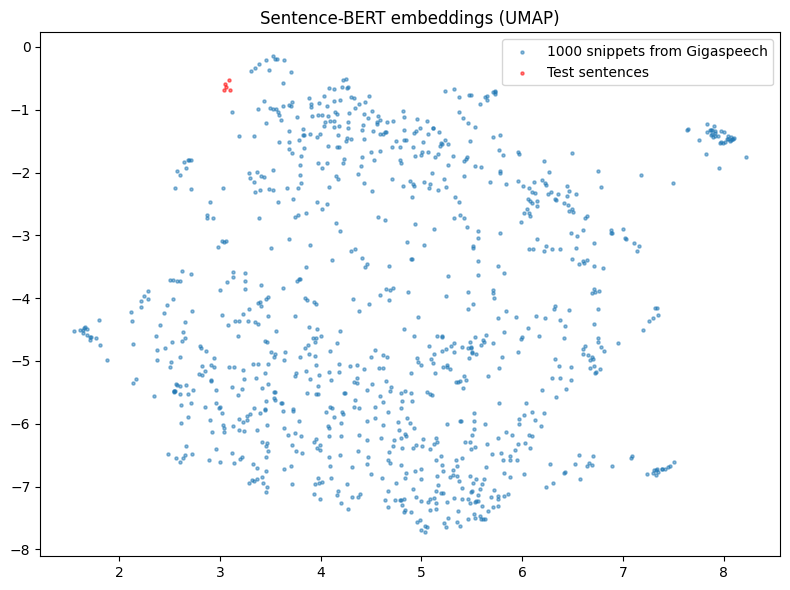

In [15]:
# === Sentence-BERT Embeddings ===

# Example data
sentences_extra = [
    "Hello, how are you today?",
    "So, how is it going?",
    "How have you been?",
    "What's up?",
    "What have you been up to lately?"
]
sentences = gs['text'][:1000]
sentences += sentences_extra

# Extract embeddings
model = SentenceTransformer('all-MiniLM-L6-v2') 
embeddings = model.encode(sentences, normalize_embeddings=True) 

# UMAP projection
reducer = umap.UMAP(metric="cosine", random_state=42)
coords = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(coords[:1000, 0], coords[:1000, 1], label="1000 snippets from Gigaspeech", s = 5, alpha=0.5)
plt.scatter(coords[1000:, 0], coords[1000:, 1], color='red', label="Test sentences", s = 5, alpha=0.5)
# for i, sent in enumerate(sentences):
#     plt.text(coords[i, 0], coords[i, 1], str(i), fontsize=5)

plt.title("Sentence-BERT embeddings (UMAP)")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# === WizMap Visualization ===

# Generate two JSON files required by WizMap
xs = coords[:, 0].astype(float).tolist()
ys = coords[:, 1].astype(float).tolist()
texts = sentences
data_list = wizmap.generate_data_list(xs, ys, texts)
grid_dict = wizmap.generate_grid_dict(xs, ys, texts, 'Sentences')
wizmap.save_json_files(data_list, grid_dict, output_dir = '../embeddings/')


Start generating data list...
Start generating contours...
Start generating multi-level summaries...


1005it [00:00, 361237.08it/s]
100%|██████████| 6/6 [00:00<00:00, 18.82it/s]


/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/steven/anaconda3/envs/audio-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


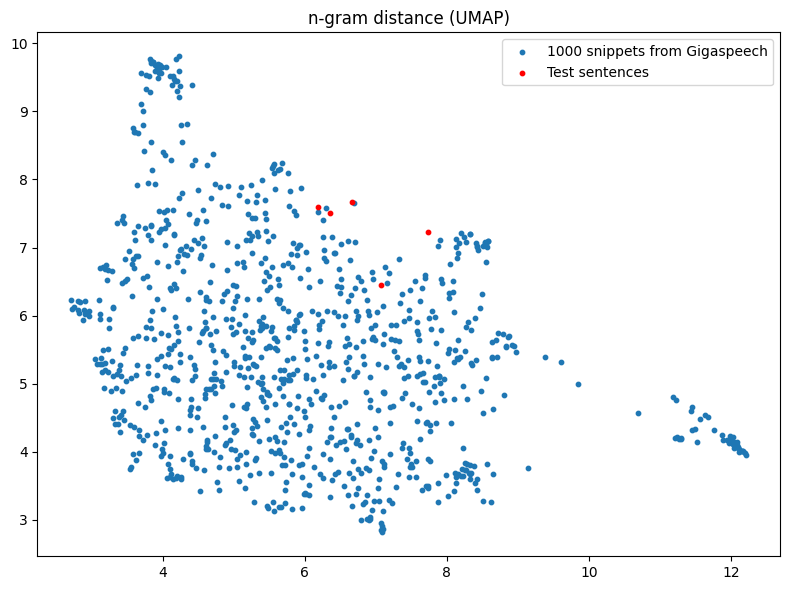

In [11]:
# Find 
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import re
from itertools import tee
from typing import List

# === 1. Preprocessing ===
def preprocess(sentence: str) -> List[str]:
    sentence = re.sub(r"[^\w\s]", "", sentence.lower())
    return sentence.split()

# === 2. Generate word-level n-grams ===
def ngrams(words: List[str], n: int) -> List[tuple]:
    return list(zip(*(tee(words, n))))

# === 3. Jaccard distance function ===
def jaccard_dist(s1: str, s2: str, n: int = 2) -> float:
    ngrams1 = set(ngrams(preprocess(s1), n))
    ngrams2 = set(ngrams(preprocess(s2), n))
    if not ngrams1 or not ngrams2:
        return 1.0  # max distance
    return 1 - len(ngrams1 & ngrams2) / len(ngrams1 | ngrams2)

# === 4. Distance matrix computation ===
def jaccard_distance_matrix(sentences: List[str], n: int = 2) -> np.ndarray:
    size = len(sentences)
    dist_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i + 1, size):
            dist = jaccard_dist(sentences[i], sentences[j], n)
            dist_matrix[i][j] = dist_matrix[j][i] = dist
    return dist_matrix


dist_matrix = jaccard_distance_matrix(sentences, n=2)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
coords2 = mds.fit_transform(dist_matrix)

import umap.umap_ as umap  # make sure you have umap-learn installed

# Compute the 2D UMAP embedding from the precomputed Jaccard distance matrix
umap_model = umap.UMAP(n_components=2, metric='precomputed', random_state=0)
coords2_umap = umap_model.fit_transform(dist_matrix)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(coords2_umap[:1000, 0], coords2_umap[:1000, 1], label="1000 snippets from Gigaspeech", s=10)
plt.scatter(coords2_umap[1000:, 0], coords2_umap[1000:, 1], color='red', label="Test sentences", s=10)
plt.title("n-gram distance (UMAP)")
plt.legend()
plt.tight_layout()
plt.show()
